# Jeremy Gwin _ Full Code ETMT Project Notebook

# Problem Statement

### Business Context

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

### Data Description

* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to college student), Post-Graduate, Doctorate
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank (in months)
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio

- The data set is composed of information from Thera Bank credit card customers. THe bank has exprianced an increase in credt card customer attrition. The purpose of the project is to analyze the data set and develope a model that can accuratly identify credit card customer who are a churn risk.


*** The notebook has been formatted so lengthy code blocks are built as defined functions at the top. This is done to help aid the flow of data output and visualizations as they will be produced with a single call line bringing pertenant information closer to gether in the notebook's flow.

**** In the Defined Function section: there will be a function number and a detailed description of what each function does for each function.

**** In the Execution section: The call line where the funciton is executed will have the funciton number and a brief reminder of the function's purpose.

- Model Evaluation
** When considering the scores produced when testing a classification problem, Recall is the one we will focus on most with this project. THat is due to the cost of not idetifying a customer intent on leaving versus the other socring metrics.

# Install & Import

In [ ]:
# Install the imbalce-learn package
!pip install imbalanced-learn==0.8.1

In [ ]:
# Import Libraires

## Utilities
import math
import sklearn as sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

## Pre-Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


## Sampleing
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


## Model Training
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


## Model Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.exceptions import FitFailedWarning


## Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


## Suppress Warnings
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.ensemble._weight_boosting")
warnings.filterwarnings("ignore", category=UserWarning, message="No artists with labels found to put in legend")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="The 'max_features' parameter of GradientBoostingClassifier must be", category=UserWarning)
warnings.filterwarnings("ignore", message="The score on these train-test partitions for these parameters will be set to nan.", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
pd.set_option('display.max_columns', None)


# Defined Functions

In [ ]:
# Function 1:
## This function outputs a custom table populated with imprtant attributes for the features within the dataset.
## Statistics Included: NaN Counts - Outlier Percentages - Data Types - Unique Values

def summary_table(df, exclude_columns=[]):
    # NaN counts
    nan_counts = df.isna().sum().to_frame(name='NaN Count')

    # Outlier percentages
    outlier_percentages = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        if column not in exclude_columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outliers = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
            outlier_percentages[column] = (outliers.sum() / df.shape[0]) * 100

    outlier_percentages_df = pd.DataFrame(list(outlier_percentages.items()), columns=['Column', 'Outlier Percentage'])

    # Data types
    data_types = df.dtypes.to_frame(name='Data Type')

    # Unique value counts
    unique_value_counts = df.nunique().to_frame(name='Unique Value Count')

    # Combine NaN counts, data types, unique value counts, and outlier percentages
    summary_table = nan_counts.join(data_types).join(unique_value_counts).join(outlier_percentages_df.set_index('Column'), how='left')

    # Display the DataFrame as an interactive table
    display(summary_table)

In [ ]:
# Function 2
## THis function automaticaly detects all continuos features and outputs a histogram
## The histograms displays the distribution of each independent varible in regard to its associattion with the Binary Y varible

def plot_continuous_distribution(df, y_variable, exclude_features=[], num_cols=3, show_legend=True):
    # Filter features based on exclusion list
    continuous_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_features)
    num_features = len(continuous_features)

    # Determine the number of rows for subplots
    num_rows = math.ceil(num_features / num_cols)

    # Plot histograms for continuous features
    plt.figure(figsize=(6*num_cols, 4*num_rows))
    for i, feature in enumerate(continuous_features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(data=df, x=feature, hue=y_variable, kde=True)
        plt.title(f'{feature} current = 1 attrited = 0')
        plt.xlabel(feature)
        plt.ylabel('Count')
        if show_legend:
            plt.legend(title=y_variable)
    plt.tight_layout()
    plt.show()

In [ ]:
# Function 3
## This function automatically detects all catergorical veriables and outputs a distribution chart for each
## Each independent varible has two distribution charts, one for each value of the Binary Y.

def plot_categorical_distribution_pie(df, y_variable, exclude_features=[], show_legend=True):

    # Filter features based on exclusion list
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.drop(exclude_features)

    # Separate data based on Y variable
    df_y1 = df[df[y_variable] == 1]
    df_y0 = df[df[y_variable] == 0]

    # Determine the number of rows and columns for subplots
    num_features = len(categorical_features)
    num_cols = 2  # Two pie charts for each binary value of Y
    num_rows = math.ceil(num_features / (num_cols / 2))  # Adjusted for pairs

    # Plot pie charts for categorical features
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20*num_cols, 5*num_rows))

    # Flatten axes array if necessary
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    elif num_cols == 1:
        axes = axes.reshape(-1, 1)
    else:
        axes = axes.reshape(num_rows, -1)

    for i, feature in enumerate(categorical_features):
        # Plot pie chart for Y=0
        ax = axes[i, 0]  # Adjusted for pairs and ensuring Y=0 is on the left

        counts_y0 = df_y0[feature].value_counts()
        total_y0 = counts_y0.sum()

        wedges, _, autotexts = ax.pie(counts_y0, labels=counts_y0.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'{feature} (Y=0 - Attrited)')
        ax.set_xlabel(f'Total: {total_y0}')

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)

        # Plot pie chart for Y=1
        ax = axes[i, 1]  # Adjusted for pairs and ensuring Y=1 is on the right
        counts_y1 = df_y1[feature].value_counts()
        total_y1 = counts_y1.sum()

        wedges, _, autotexts = ax.pie(counts_y1, labels=counts_y1.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'{feature} (Y=1 - Current)')
        ax.set_xlabel(f'Total: {total_y1}')

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)

    plt.tight_layout()
    if show_legend:
        plt.legend()
    plt.show()

In [ ]:
# Function 4
## This function outputs a heatmap for all varibles
## THere is a heatmap for each values of the Binary Y

def binary_heatmap(df, y_variable, drop_features=[], exclude_features=[]):
    # Drop specified features from the original dataframe
    df = df.drop(drop_features, axis=1, errors='ignore')

    # One-hot-encode the categorical Y variable column without dropping the first category
    df_encoded = pd.get_dummies(df, columns=[y_variable], drop_first=False)

    # Selecting continuous variables and removing excluded features
    continuous_variables = df_encoded.select_dtypes(include=['float64', 'int64']).columns
    continuous_variables = [col for col in continuous_variables if col not in exclude_features]

    # Create heatmaps for each one-hot-encoded Y variable column
    for encoded_col in df_encoded.columns:
        if encoded_col.startswith(y_variable + '_'):  # Adjusted to ensure it only selects encoded columns
            plt.figure(figsize=(20, 6))
            # Create a correlation matrix including the encoded column and continuous variables
            corr_matrix = df_encoded[[encoded_col] + list(continuous_variables)].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title(f'Heatmap for {encoded_col} existing = 1 attrited = 0')
            plt.tight_layout()
            plt.show()


In [ ]:
# Function 5
## THis function applies the data pre-processing required to preapre the data set for model training
## Step 1: Impute missing continuous values
## Step 2: Impute missing catergorical values
## Step 3: One-hot-encode catergoical values

def preprocess(df, impt_cont=[], impt_cat=[], OHE=[]):
    # Impute the designated continuous columns
    for col in impt_cont:
        df[col].fillna(df[col].mean(), inplace=True)

    # Impute the designated categorical columns
    for col in impt_cat:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Perform one-hot encoding for the designated categorical columns
    for col in OHE:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col])

    return df

In [ ]:
# Function 6
## This function outputs a concatened table of the trained models perfromance scores
## There is an additonal score column that displays the mean of all the scores for each model
## This fucntion enables a more efficent evaluation of model performance due to the tables data maniplulation and visualization features

def combined_train_scores():
    # Define model names
    model_names_og = ['Decision Tree_OG', 'Bagging_OG', 'Random Forest_OG', 'AdaBoost_OG', 'Gradient Boost_OG', 'XGBoost_OG']
    model_names_us = ['Decision Tree_US', 'Bagging_US', 'Random Forest_US', 'AdaBoost_US', 'Gradient Boost_US', 'XGBoost_US']
    model_names_os = ['Decision Tree_OS', 'Bagging_OS', 'Random Forest_OS', 'AdaBoost_OS', 'Gradient Boost_OS', 'XGBoost_OS']

    # Define scores for each scenario
    scores_og = {
        'Accuracy': [dt_og_accuracy, bagging_accuracy_og, random_forest_accuracy_og, adaboost_accuracy_og, gradient_boost_accuracy_og, xgboost_accuracy_og],
        'Precision': [dt_og_precision, bagging_precision_og, random_forest_precision_og, adaboost_precision_og, gradient_boost_precision_og, xgboost_precision_og],
        'Recall': [dt_og_recall, bagging_recall_og, random_forest_recall_og, adaboost_recall_og, gradient_boost_recall_og, xgboost_recall_og],
        'F1 Score': [dt_og_f1, bagging_f1_og, random_forest_f1_og, adaboost_f1_og, gradient_boost_f1_og, xgboost_f1_og]
    }

    scores_us = {
        'Accuracy': [dt_us_accuracy, bagging_accuracy_us, random_forest_accuracy_us, adaboost_accuracy_us, gradient_boost_accuracy_us, xgboost_accuracy_us],
        'Precision': [dt_us_precision, bagging_precision_us, random_forest_precision_us, adaboost_precision_us, gradient_boost_precision_us, xgboost_precision_us],
        'Recall': [dt_us_recall, bagging_recall_us, random_forest_recall_us, adaboost_recall_us, gradient_boost_recall_us, xgboost_recall_us],
        'F1 Score': [dt_us_f1, bagging_f1_us, random_forest_f1_us, adaboost_f1_us, gradient_boost_f1_us, xgboost_f1_us]
    }

    scores_os = {
        'Accuracy': [dt_os_accuracy, bagging_accuracy_os, random_forest_accuracy_os, adaboost_accuracy_os, gradient_boost_accuracy_os, xgboost_accuracy_os],
        'Precision': [dt_os_precision, bagging_precision_os, random_forest_precision_os, adaboost_precision_os, gradient_boost_precision_os, xgboost_precision_os],
        'Recall': [dt_os_recall, bagging_recall_os, random_forest_recall_os, adaboost_recall_os, gradient_boost_recall_os, xgboost_recall_os],
        'F1 Score': [dt_os_f1, bagging_f1_os, random_forest_f1_os, adaboost_f1_os, gradient_boost_f1_os, xgboost_f1_os]
    }

    # Create DataFrames
    scores_og_df = pd.DataFrame(scores_og, index=model_names_og)
    scores_us_df = pd.DataFrame(scores_us, index=model_names_us)
    scores_os_df = pd.DataFrame(scores_os, index=model_names_os)

    # Concatenate DataFrames
    combined_scores_df = pd.concat([scores_og_df, scores_us_df, scores_os_df], keys=['Original', 'UnderSampled', 'OverSampled'])

    # Add additional column for mean of the four scores
    combined_scores_df['Mean'] = combined_scores_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean(axis=1)

    return combined_scores_df

In [ ]:
# Function 7
## This function outputs a concatened plottable of the confusion matrices for the trained models
## This fucntion enables a more efficent evaluation of model performance due to proximity of each visualization to the others

def plot_train_confusion_matrix():
    # Create a figure and axes with the desired size
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

    # Define classifiers and their corresponding confusion matrices for Original, Undersampled, and Oversampled
    classifiers = [
        ("Decision Tree_OG", dt_og_conf_matrix),
        ("Bagging_OG", bagging_conf_matrix_og),
        ("Random Forest_OG", random_forest_conf_matrix_og),
        ("AdaBoost_OG", adaboost_conf_matrix_og),
        ("Gradient Boost_OG", gradient_boost_conf_matrix_og),
        ("XGBoost_OG", xgboost_conf_matrix_og),
        ("Decision Tree_US", dt_us_conf_matrix),
        ("Bagging_US", bagging_conf_matrix_us),
        ("Random Forest_US", random_forest_conf_matrix_us),
        ("AdaBoost_US", adaboost_conf_matrix_us),
        ("Gradient Boost_US", gradient_boost_conf_matrix_us),
        ("XGBoost_US", xgboost_conf_matrix_us),
        ("Decision Tree_OS", dt_os_conf_matrix),
        ("Bagging_OS", bagging_conf_matrix_os),
        ("Random Forest_OS", random_forest_conf_matrix_os),
        ("AdaBoost_OS", adaboost_conf_matrix_os),
        ("Gradient Boost_OS", gradient_boost_conf_matrix_os),
        ("XGBoost_OS", xgboost_conf_matrix_os)
    ]

    # Plot confusion matrices in subplots
    for i, (title, matrix) in enumerate(classifiers):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        im = ax.imshow(matrix, cmap=plt.cm.Blues)
        ax.set_title((title))

        # Loop over data dimensions and create text annotations
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# Function 8
## This function outputs a concatened table of the optimized hyperparameters for each model
## This fucntion enables a more efficent evaluation of optimized hyperparameters for each model due to the data manipulation features of the interactive table

def generate_hyperparameters_table():
    # List of models and their names
    models = [rand_search_adaboost_og, rand_search_gradient_boost_og, rand_search_xgboost_og, rand_search_dt_os, rand_search_rf_os, rand_search_xgboost_os]
    model_names = ['AdaBoost', 'Gradient Boosting', 'XGBoost', 'Decision Tree with Oversampling', 'Random Forest with Oversampling', 'XGBoost with Oversampling']

    # Initialize a dictionary to store hyperparameters
    hyperparameters_dict = {}

    # Extract hyperparameters for each model
    for model, model_name in zip(models, model_names):
        hyperparameters = model.best_params_
        for param_name, param_value in hyperparameters.items():
            if param_name not in hyperparameters_dict:
                hyperparameters_dict[param_name] = ['na'] * len(models)
            hyperparameters_dict[param_name][model_names.index(model_name)] = param_value

    # Create a DataFrame to display the hyperparameters
    hyperparameters_table = pd.DataFrame(hyperparameters_dict)
    hyperparameters_table['Model'] = model_names  # Add the 'Model' column
    hyperparameters_table.set_index('Model', inplace=True)  # Set 'Model' column as index

    return hyperparameters_table

In [ ]:
# Function 9
## This function outputs a concatened table of the tuned models perfromance scores
## There is an additonal score column that displays the mean of all the scores for each model
## This fucntion enables a more efficent evaluation of model performance due to the tables data maniplulation and visualization features

def combined_validate_scores():
    # Define model names
    model_names_og = ['Best AdaBoost_OG', 'Best Gradient Boost_OG', 'Best XGBoost_OG']
    model_names_os = ['Best Decision Tree_OS', 'Best Random Forest_OS', 'Best XGBoost_OS']

    # Define scores for each scenario
    scores_og_val = {
        'Accuracy': [adaboost_og_accuracy_val, gradient_boost_og_accuracy_val, xgboost_og_accuracy_val],
        'Precision': [adaboost_og_precision_val, gradient_boost_og_precision_val, xgboost_og_precision_val],
        'Recall': [adaboost_og_recall_val, gradient_boost_og_recall_val, xgboost_og_recall_val],
        'F1 Score': [adaboost_og_f1_val, gradient_boost_og_f1_val, xgboost_og_f1_val]
    }

    scores_os_val = {
        'Accuracy': [dt_os_accuracy_val, rf_os_accuracy_val, xgboost_os_accuracy_val],
        'Precision': [dt_os_precision_val, rf_os_precision_val, xgboost_os_precision_val],
        'Recall': [dt_os_recall_val, rf_os_recall_val, xgboost_os_recall_val],
        'F1 Score': [dt_os_f1_val, rf_os_f1_val, xgboost_os_f1_val]
    }

    # Create DataFrames
    scores_og_df_val = pd.DataFrame(scores_og_val, index=model_names_og)
    scores_os_df_val = pd.DataFrame(scores_os_val, index=model_names_os)

    # Concatenate DataFrames
    combined_val_scores_df = pd.concat([scores_og_df_val, scores_os_df_val], keys=['Original', 'OverSampled'])

    # Add additional column for mean of the four scores
    combined_val_scores_df['Mean'] = combined_val_scores_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean(axis=1)

    return combined_val_scores_df

In [ ]:
## Function 10
## This function outputs a concatened plottable of the confusion matrices for the tuned models
## This fucntion enables a more efficent evaluation of model performance due to proximity of each visualization to the others

def plot_validate_confusion_matrix():
    # Create a figure and axes with the desired size
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Define classifiers and their corresponding confusion matrices for Original, Undersampled, and Oversampled
    classifiers = [
        ("Best AdaBoost_OG", adaboost_og_val_conf_matrix),
        ("Best Gradient Boost_OG", gradient_boost_og_val_conf_matrix),
        ("Best XGBoost_OG", xgboost_og_val_conf_matrix),
        ("Best Decision Tree_OS", dt_os_val_conf_matrix_val),
        ("Best Random Forest_OS", rf_os_val_conf_matrix),
        ("Best XGBoost_OS", xgboost_os_val_conf_matrix_val)
    ]

    # Plot confusion matrices in subplots
    for i, (title, matrix) in enumerate(classifiers):
        ax = axes[i // 3, i % 3]  # Adjusting the indexing to get the correct subplot
        im = ax.imshow(matrix, cmap=plt.cm.Blues)
        ax.set_title(title)

        # Loop over data dimensions and create text annotations
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# Fucntion 11
## This function outputs a table of the final models performance on the test data
## This fucntion enables a more efficent visualization of the final models scores due to the features of the interactive table

def test_scores():
    # Define model names
    model_names_og = ['Best Gradient Boost_OG']

    # Calculate scores
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)

    # Define scores for each scenario
    test_scores = {
        'Accuracy': [test_accuracy],
        'Precision': [test_precision],
        'Recall': [test_recall],
        'F1 Score': [test_f1]
    }

    # Create DataFrames
    test_scores_df = pd.DataFrame(test_scores, index=model_names_og)

    # Add additional column for mean of the four scores
    test_scores_df['Mean'] = test_scores_df.mean(axis=1)

    return test_scores_df

In [ ]:
## Function 12
## This function outputs a confusion matrix the final model's perfromance on the test data.

def plot_test_confusion_matrix():
    # Get the confusion matrix for test predictions
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Create a figure and axes with the desired size
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the confusion matrix
    im = ax.imshow(test_conf_matrix, cmap=plt.cm.Blues)
    ax.set_title("Confusion Matrix for Test Data")

    # Loop over data dimensions and create text annotations
    for i in range(test_conf_matrix.shape[0]):
        for j in range(test_conf_matrix.shape[1]):
            text = ax.text(j, i, test_conf_matrix[i, j], ha="center", va="center", color="black")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Load Data Set

In [ ]:
# Load the dataset
data = pd.read_csv('BankChurners.csv')

# Create a working data frame
df = data.copy()


# General Information

In [ ]:
# View the first 5 lines of data frame: df
df.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_Q4_Q1,total_trans_amt,total_trans_ct,total_ct_chng_Q4_Q1,avg_utilization_ratio
0,1,45,F,3,High School,Married,Less than $40K,Blue,36,4,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469
1,0,58,M,0,NaN,Single,$40K - $60K,Blue,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
2,0,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,6,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214
3,1,34,F,2,Uneducated,Single,Less than $40K,Blue,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,1,49,F,2,Uneducated,Married,abc,Blue,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239


In [ ]:
# CLIENTNUM	is not a useful feature and will be dropped for the model building process

## Drop Client ID Number
df = df.drop(['CLIENTNUM'], axis=1)


# THe Y is binary encoded for the model building process

## Binary Encode Y | Existing Customer = 1 : Attrited Customer = 0
label_encoder = LabelEncoder()
df['attrition_flag'] = label_encoder.fit_transform(df['attrition_flag'])


## View the head to ensure the binary encoding process was successful
df.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_Q4_Q1,total_trans_amt,total_trans_ct,total_ct_chng_Q4_Q1,avg_utilization_ratio
0,1,45,F,3,High School,Married,Less than $40K,Blue,36,4,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469
1,0,58,M,0,NaN,Single,$40K - $60K,Blue,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
2,0,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,6,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214
3,1,34,F,2,Uneducated,Single,Less than $40K,Blue,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,1,49,F,2,Uneducated,Married,abc,Blue,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239


In [ ]:
# Function 1: Feature Attribute Summary Table

summary_table(df, exclude_columns=[])

,NaN Count,Data Type,Unique Value Count,Outlier Percentage
attrition_flag,0,int64,2,16.065962
customer_age,0,int64,45,0.019749
gender,0,object,2,NaN
dependent_count,0,int64,6,0.000000
education_level,1519,object,6,NaN
marital_status,749,object,3,NaN
income_category,0,object,6,NaN
card_category,0,object,4,NaN
months_on_book,0,int64,44,3.811593
total_relationship_count,0,int64,6,0.000000


- This table reveals the proportinal split of the Binary Y. THe Majority Class Makes up 84% of the dataset and the Minority Class represents 16%.

- There are 1519 missing values in the Education Level feature and 749 missing values in the Marital Status festure. THese will be addressed during pre=processing.

- Credit Limit, Average Open to Buy, and Total transaction Amount have marginally high outlier percentages. We will review them further in the EDA to determine if we need to apply a treatment before training the models.

# EDA

In [ ]:
# Descrtiptive Statistics of the data set

df.describe()

,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_Q4_Q1,total_trans_amt,total_trans_ct,total_ct_chng_Q4_Q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.839340,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,1.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,1.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,1.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


- As previously noted with the outlier percentage, Credit Limit, Average Open to Buy, and Total transaction Amount, have signifigant STD and Ranges indicating signifigant outliers.

## Continuous Varibles

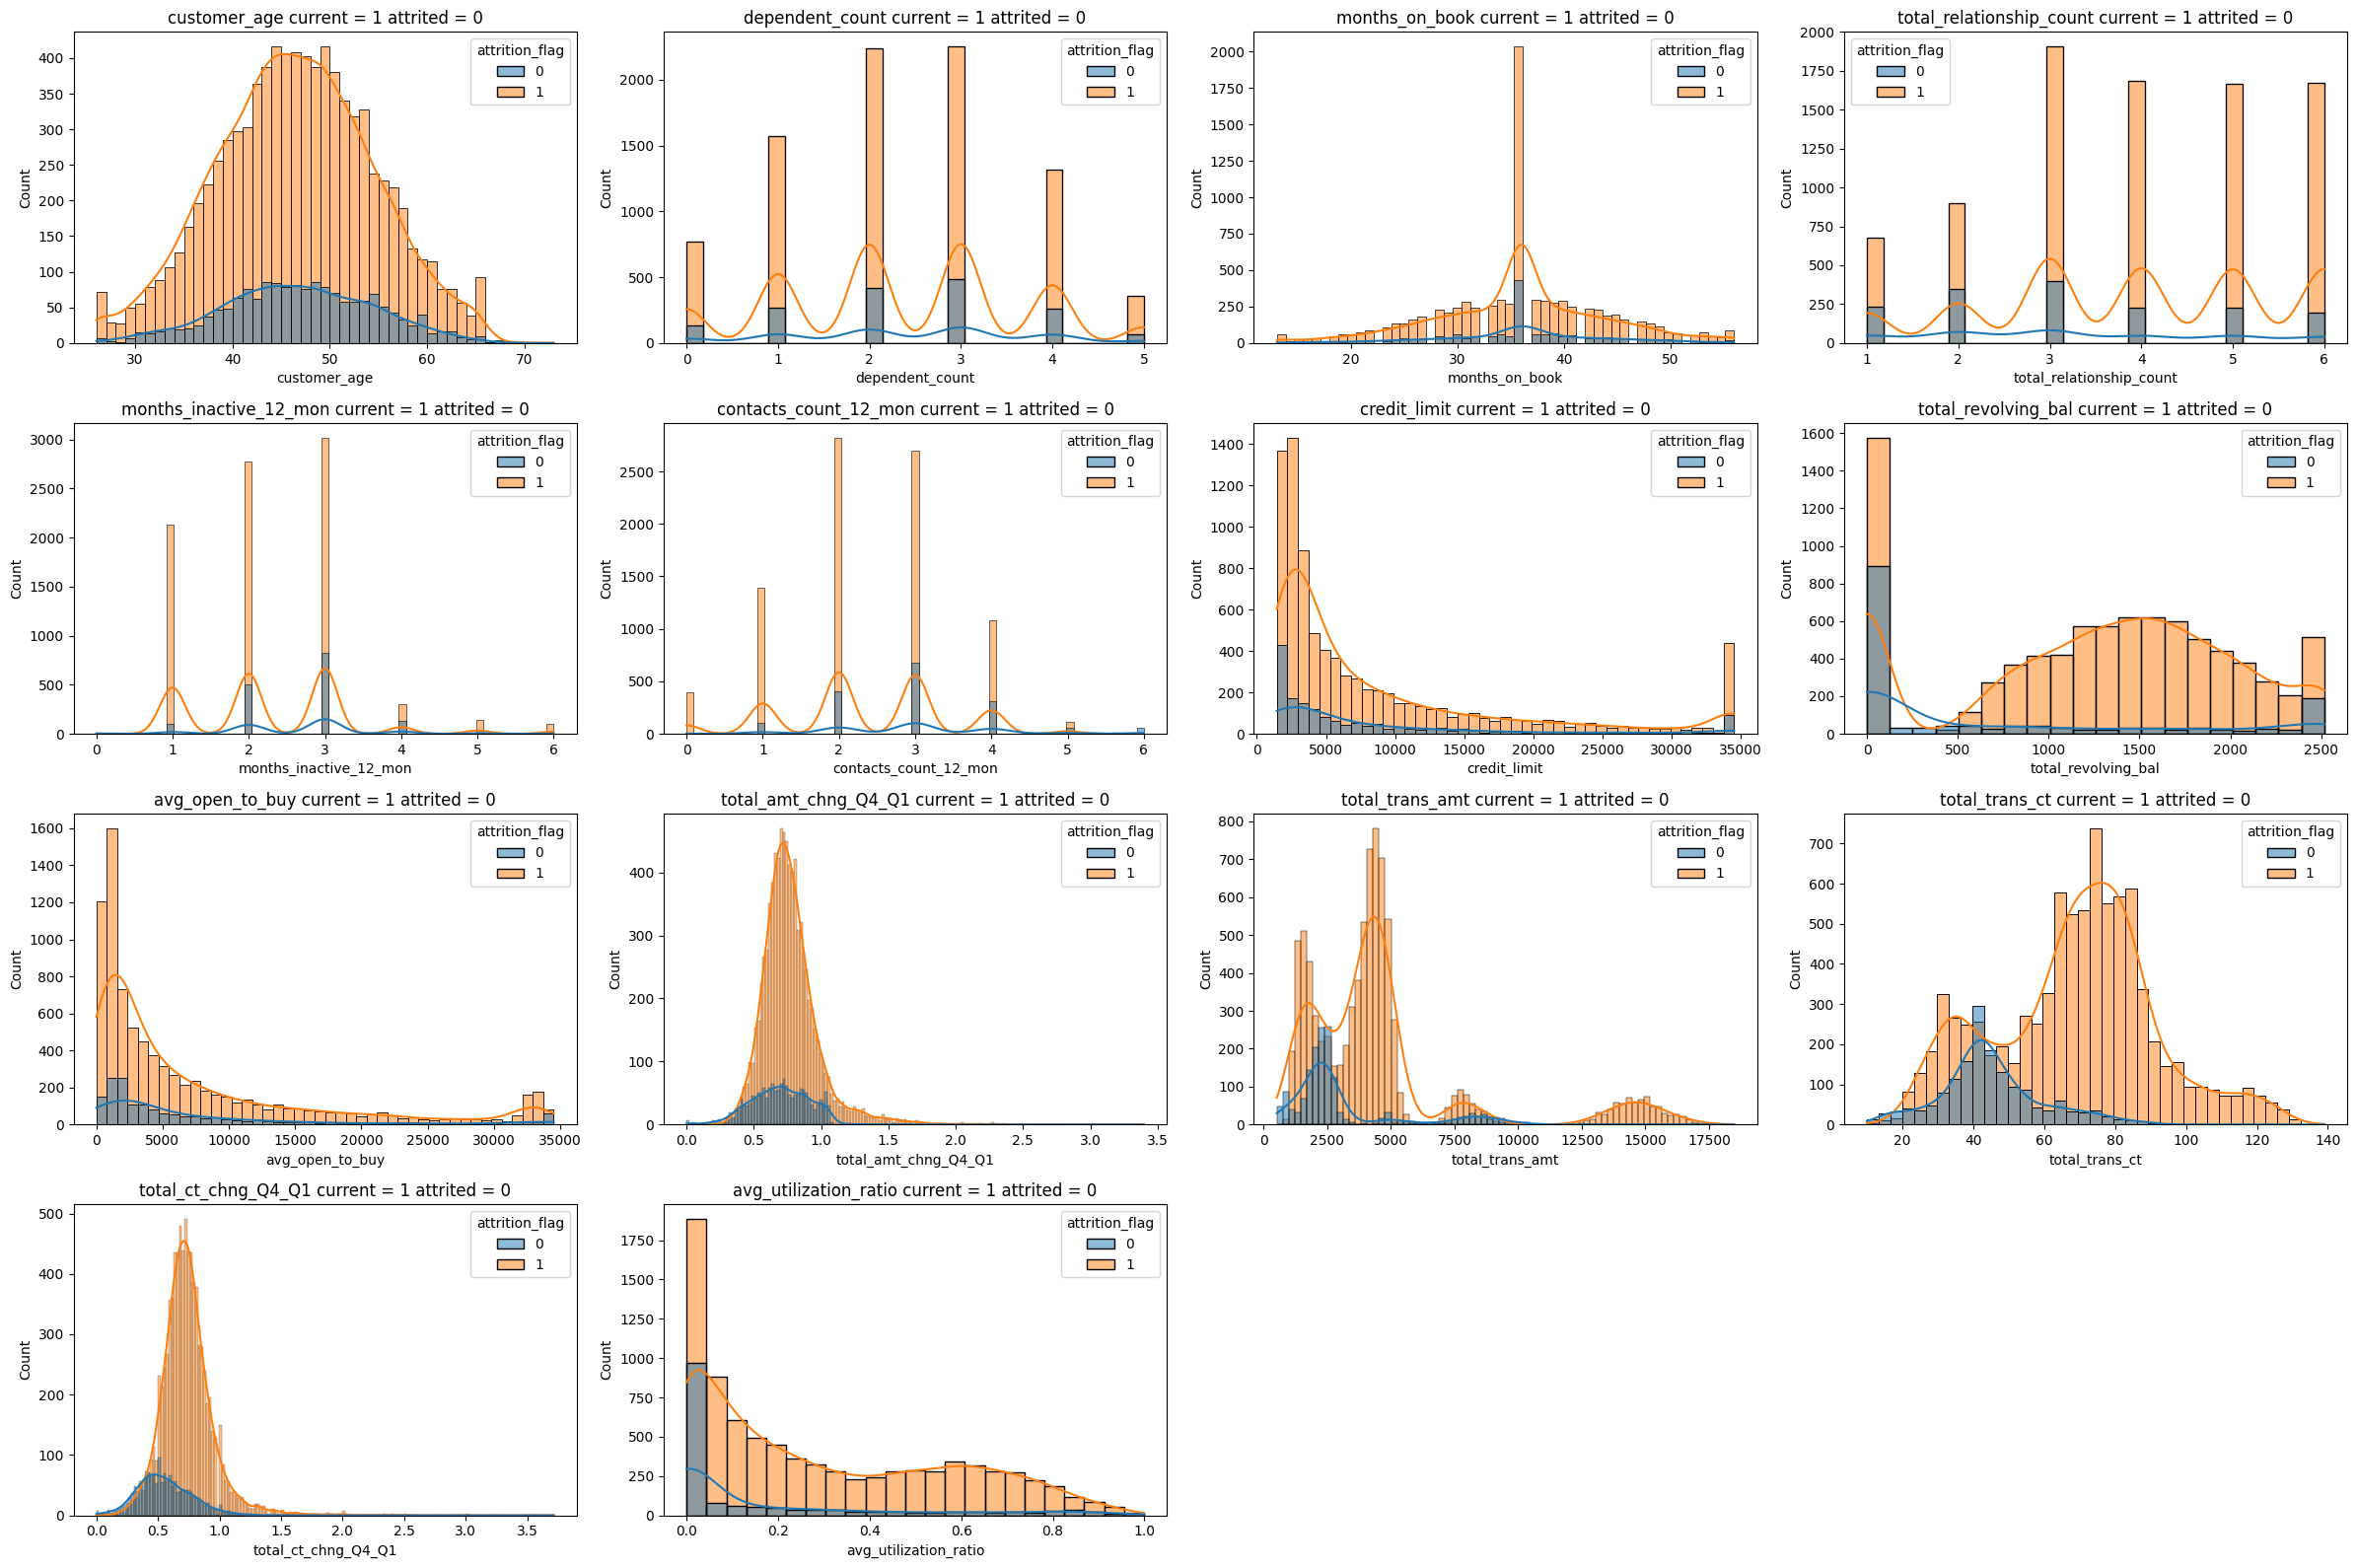

In [ ]:
# Function 2: Distribution of Continous Varibles for Each Binary Y value | Orange = Current Customer & Blue = Attrited Customer

plot_continuous_distribution(df, 'attrition_flag', exclude_features=['attrition_flag'], num_cols=4, show_legend=False)

Continuous Features Distribution Comments
- Customer Age
  - Both: Near normal distribution
- Dependent Count
  - Both: Near normal distribution
- Months on Book
  - Both: Abnormal Distribution with extreme central mode
-Total Realtionship Count
  - Current Cusotmer: Slight left skew
  - Attrited Customers: Slight right skew
- Months Inactive past 12 months
  - Both: Slight right skew
- Contact Count last 12 months
  - Both: Slight right skew
- Credit Limit
  - Current Customers: Abnormal near exponential
  - Attrited Customers: Abnormal near exponential
- Total Revolving Balance
  - Both: Abnormal multi-modal distribution
- Average Open to Buy
  - Both: Abnormal near expotential distribution
- Total Amount Change Q4 to Q1
  - Both: Near normal distribution
- Total Transaction Amount
  - Both: Abmnormal multi-modal
- Transaction Total Count
  - Current: Abnormal multi-modal
  - Attrited: Near normal distribution
- Total Transaction Count
  - Current Customers: Abnormal muilti-modal distribution
  - Attrited Customers: Near normal distribution
- Total Tranction Count Change Q4 to Q1
  - Both: Near normal distribution
- Average utilization ration
  - Both: Abnormal near expotential distribution

**** Due to the use of tree models and thier robustness against non-gaussian distributions and outliers, the data should not require treatment to address the pressence of these conditions in the data set..

## Categorical Features

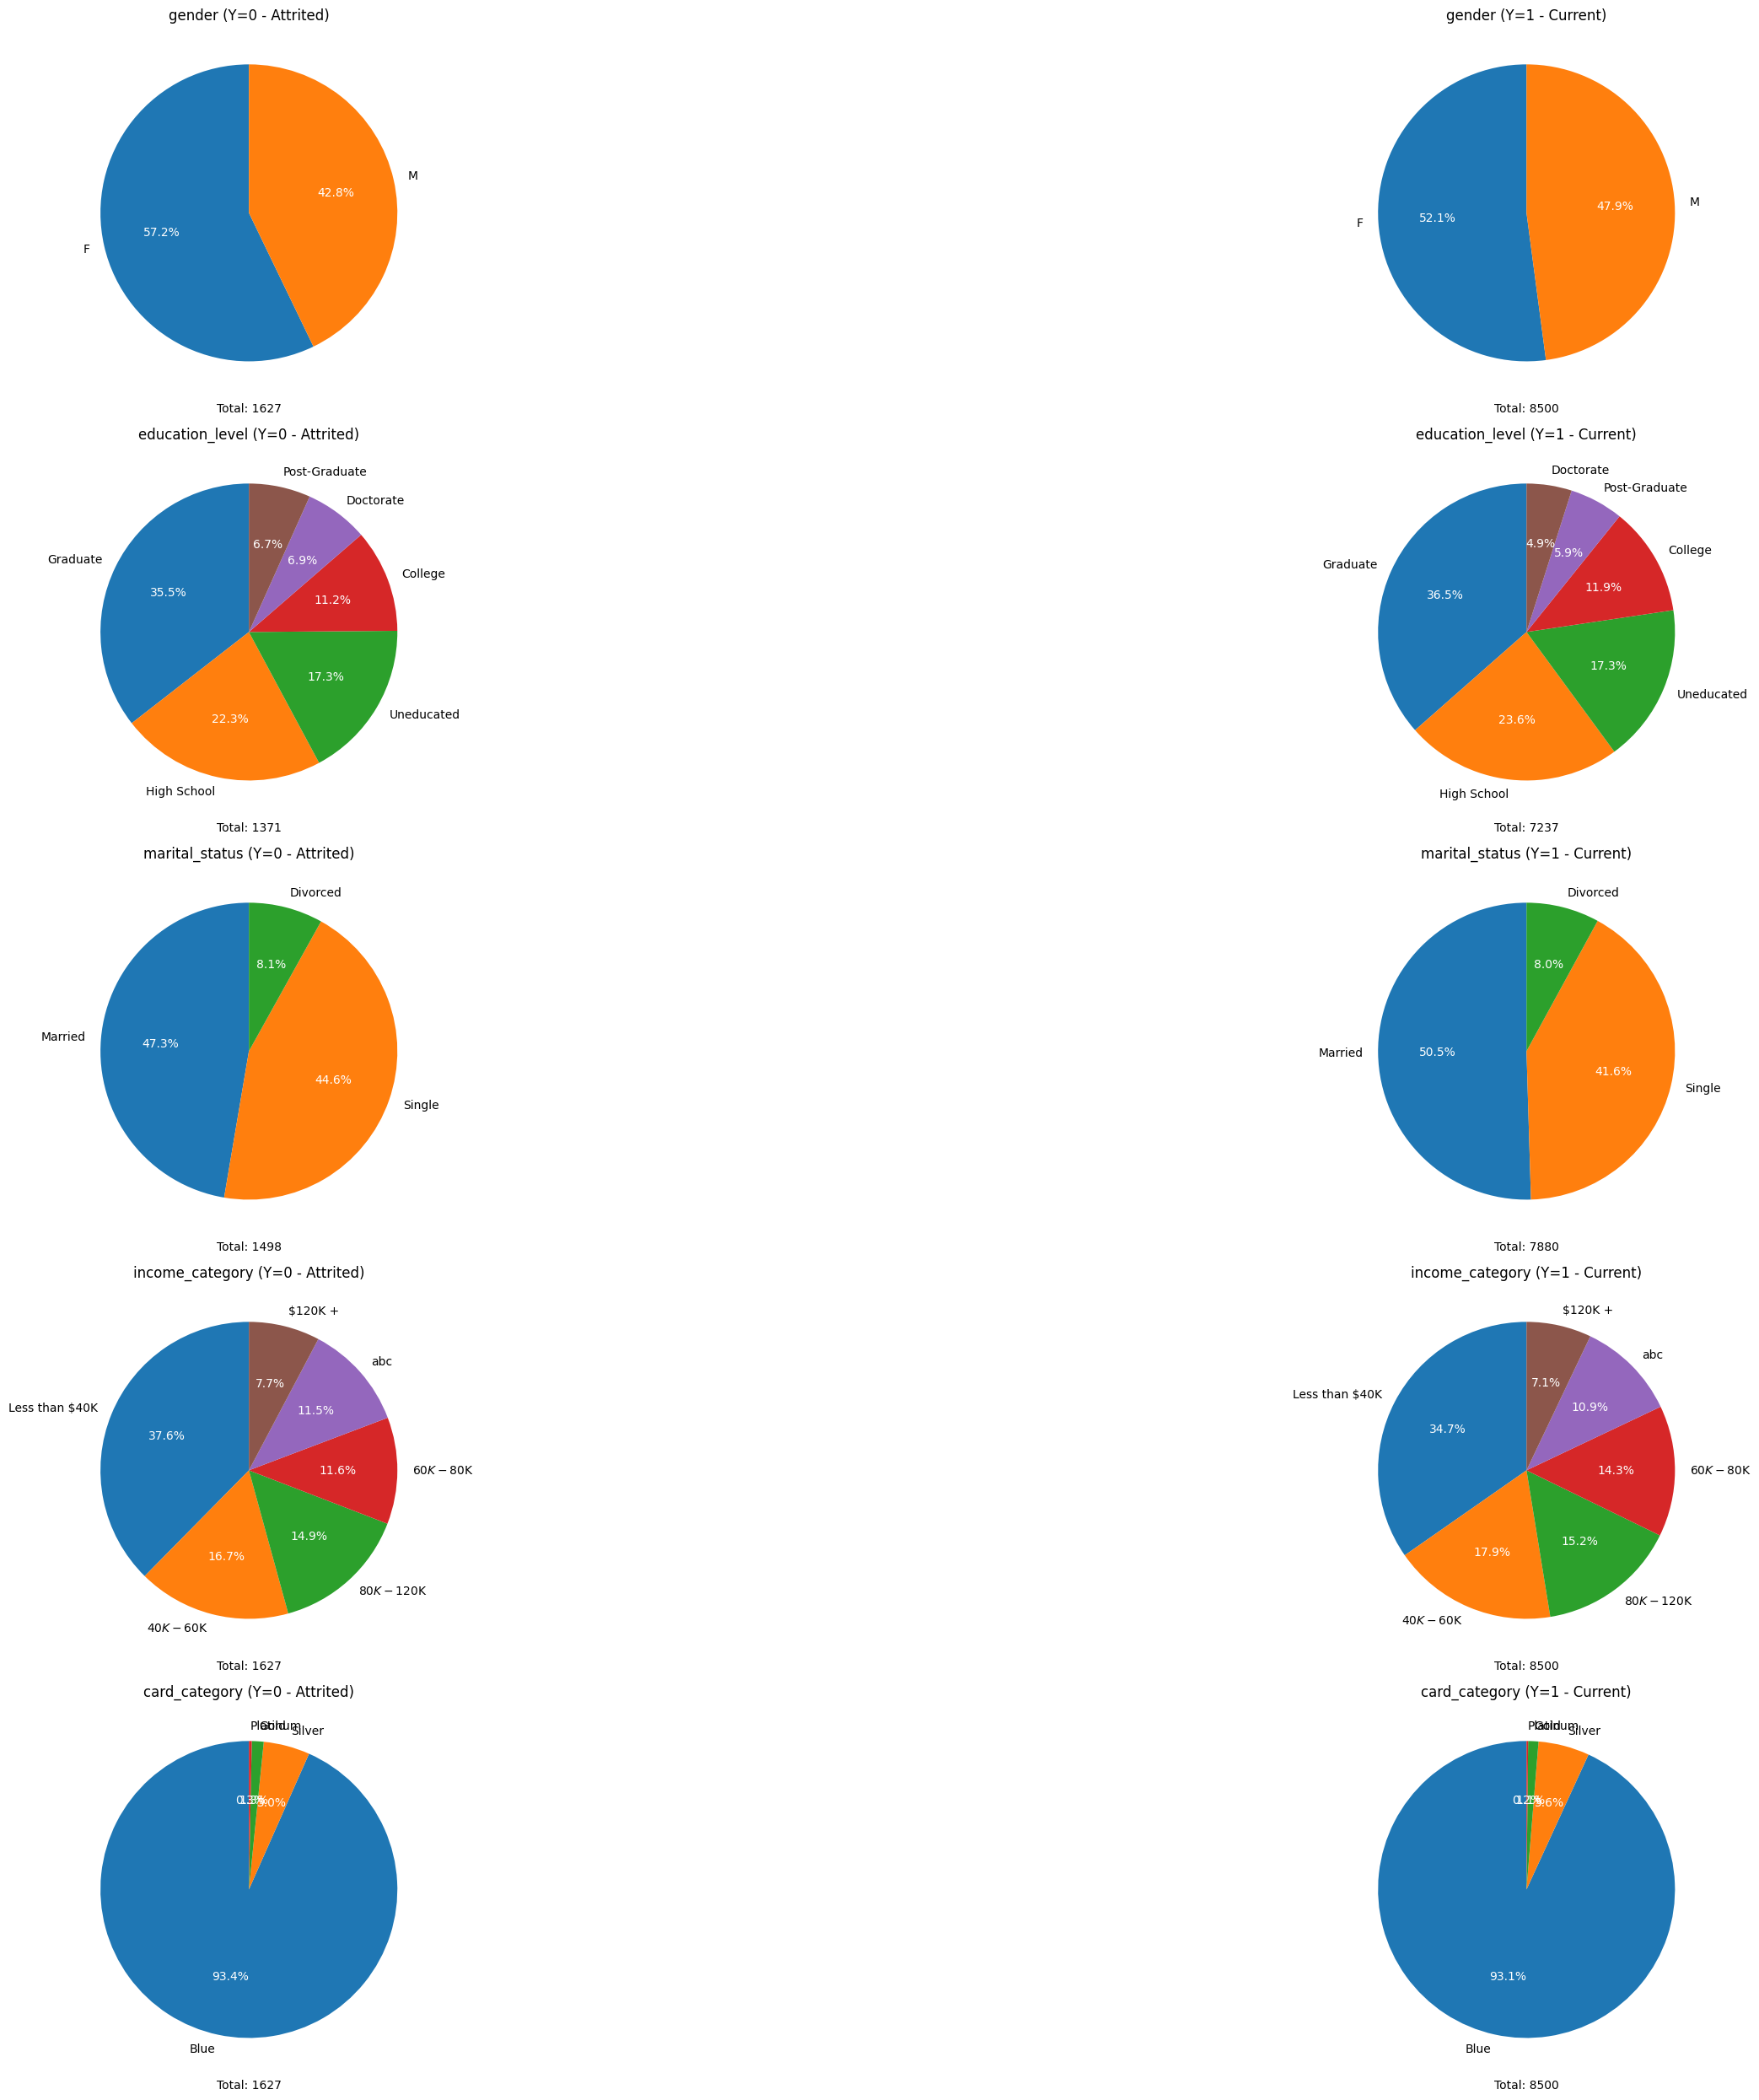

In [ ]:
# Function 3: Distribution of catergorical variables segregated by Y binary value

plot_categorical_distribution_pie(df, 'attrition_flag', exclude_features=[], show_legend=False)

Catergorical Distribution Comments
- Gender
  -  Attrited = Current

- Customer Education Level
  - Attrited: Post Graduate + Doctorate > Current: Post Graduate + Doctorate

- Marital Status
 - Attrited = Current

- Income Level Catergory
  - Attrited: 60-80K < Current: 60-80K

- Card Level
  - Attrited = Current

## Correlation Coeffcients

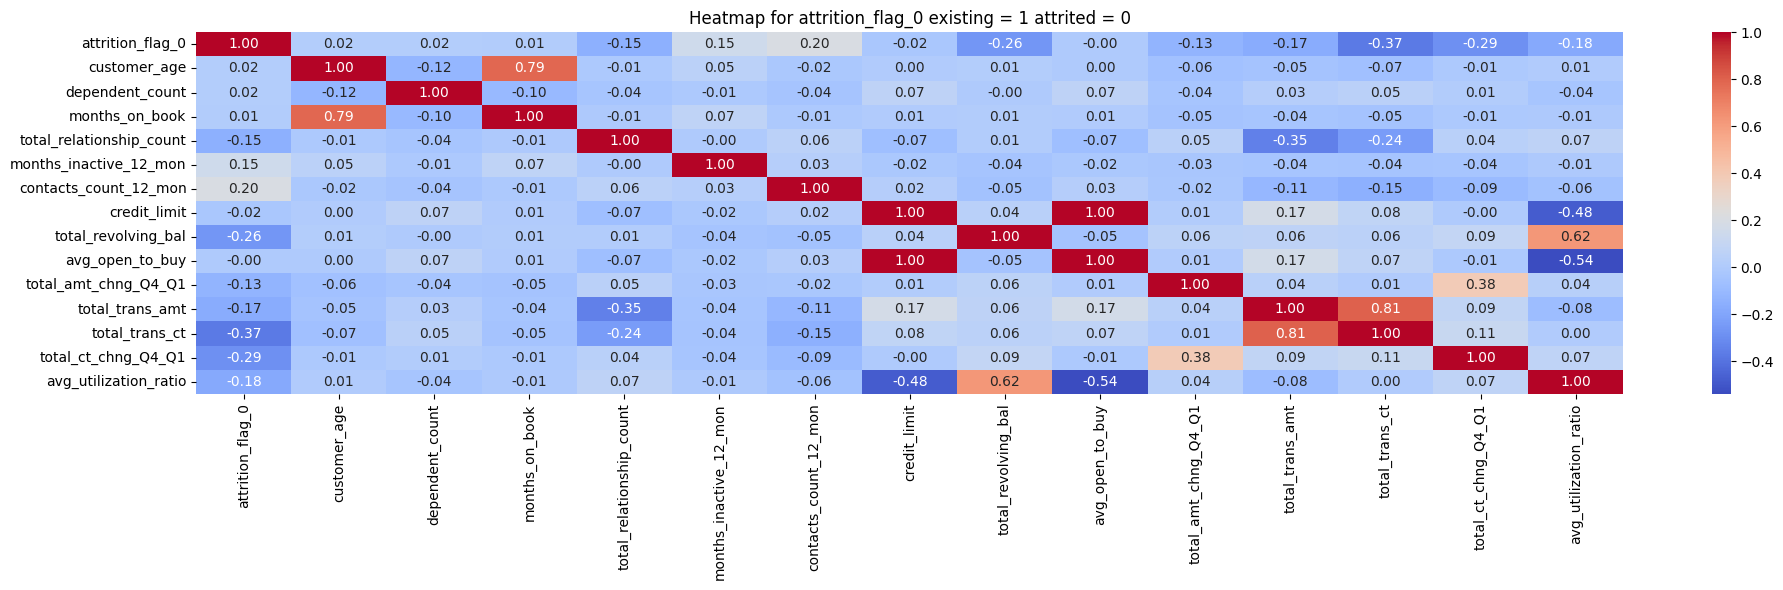

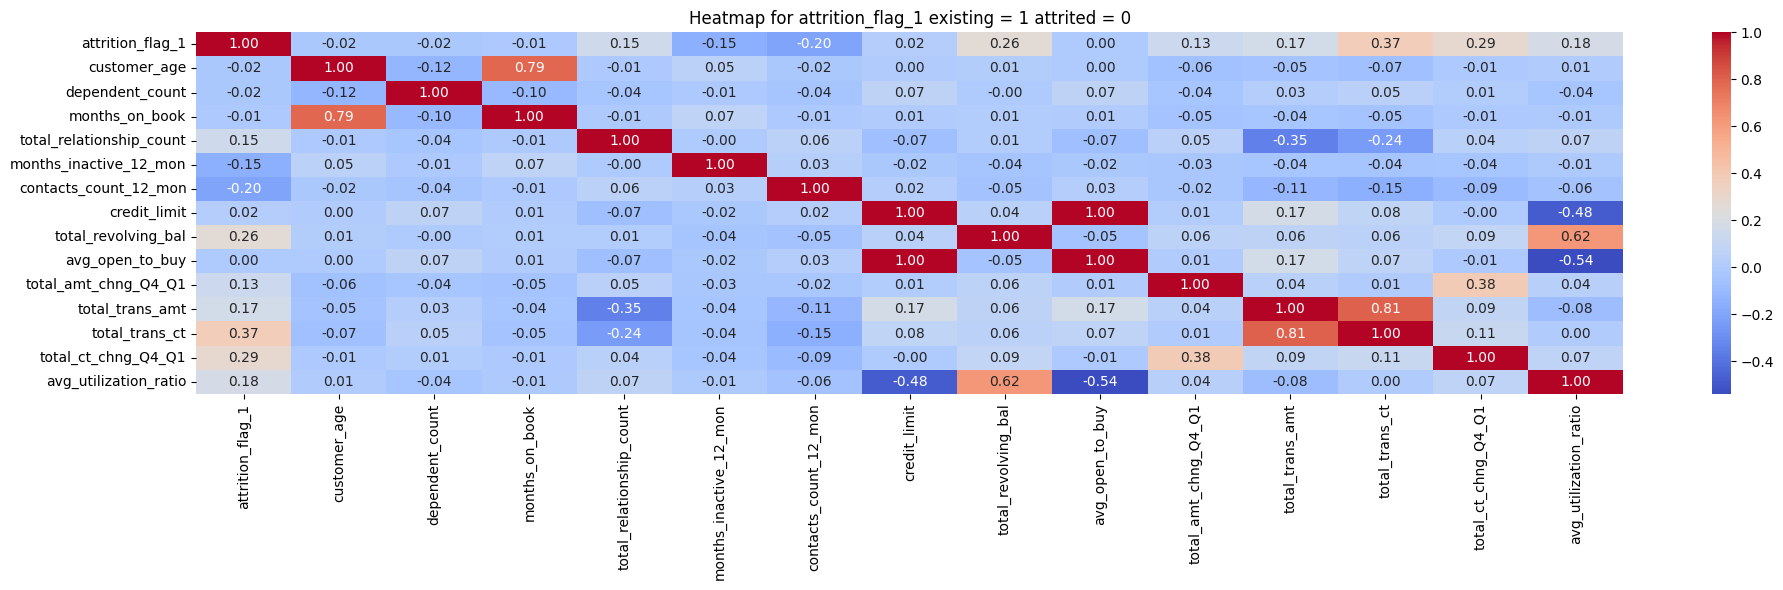

In [ ]:
# Function 4

binary_heatmap(df, 'attrition_flag', drop_features=[], exclude_features=[])

Correlation Coeffcent Comments

--------------------------------------------------------------------------------

Good Positive Correlation | Current Customer vs. X
- Total Transaction Amount: a = 0.37
- Total Tanstaction Count Change Q4 to Q1: a = 0.29
- Total Revolving Balanace = a = 0.26

Weak Positive Correlation | Current Customer vs. X
- Average Utilizaton Rate: a = 0.18
- Total Transaction Amount: a = 0.17
- Total Amount Change from Q4 to Q1: a = 0.13
- Total Realtionship Count: a = 0.15

--------------------------------------------------------------------------------

Good Positive Correlation | Attrited Customer  vs. X
- Contact Count in Past 12 mo.: a = 0.20

Weak Positive Correlation | Current Customer vs. X
- Months Inactive in Past 12 mo.: a = 0.15

--------------------------------------------------------------------------------
Notes: The majority of the features informative to customer attrition status are related to customer activity level, the one exception to the is the Realtionship Count feature. This could indicate that if a customer's activity level strats to slide, efforts to reangage the sutomer might help decrease attrition rates.  


# Pre-Processing

## Impute NaN & One Hot Encode

In [ ]:
# Function 5: Missing values will be imputed & catergorical features one-hot encoded.

df=preprocess(df, impt_cont=[], impt_cat=['education_level', 'marital_status'], OHE=['gender', 'education_level', 'marital_status', 'income_category', 'card_category'])

df.head()

,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_Q4_Q1,total_trans_amt,total_trans_ct,total_ct_chng_Q4_Q1,avg_utilization_ratio,gender_F,gender_M,education_level_College,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,marital_status_Divorced,marital_status_Married,marital_status_Single,income_category_$120K +,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_abc,card_category_Blue,card_category_Gold,card_category_Platinum,card_category_Silver
0,1,45,3,36,4,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
1,0,58,0,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,0,46,3,38,6,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,1,34,2,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,1,49,2,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0


## Sampling

In [ ]:
# The sampling process in this project is critical. To prevent daa leakage during model training - tunign & testing, the data set will be split into (3) straified data set (Train - Valiate - Test)
# During the model training phase we are oign to train models using three different sampling technies
## Training Iteration 1: Orginal stratified data sample
## Training Iteration 2: THe majority class will be undersamled
## Training Iteration 3: The minority class will be oversmapled

### Split X & Y Vairables ###
X = df.drop('attrition_flag', axis=1)
y = df['attrition_flag']


### Split Data Into Train / Validate / Test Sets ###
# Split the data into training and the rest, stratified on y
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the 'rest' into validation and test sets, stratified on y_temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# split train set 80/20 to train model
X_og_train, X_og_test, y_og_train, y_og_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)



#### Under Sampleing ###
# Define the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Under Sample the Majority Class
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

# Split the data into training and testing sets
X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)


### Over sampling ###
# Initialize RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)

# Over Sample the Minority Class
X_over, y_over = over_sampler.fit_resample(X_train, y_train)

# Split the data into training and testing sets
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)


### Split for Model Tuning ###
# Split the validation set for tuning the models
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val, y_val, test_size=0.2, stratify=y_val, random_state=42)

# Model Training

Training Section / Sampling Method
- Orginal Stratafied Data
- Under Sampled
- Over sampled

Model Order:
- Decision Tree
- Bagging Classifier with Decision Tree Base
- Random Forest Classifier
- AdaBoost Classifier
- Gradient Boost Classifier
- XGBoost Clssifier

Naming Key
OG = orignal stratified data
US = under-sampoled majority class
OS = over-sampled minotiy class



## Original Data Set

In [ ]:
# Initialize the decision tree model
dt_og_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_og_model.fit(X_og_train, y_og_train)

# Test the model
y_og_pred = dt_og_model.predict(X_og_test)

# Calculate scores
dt_og_accuracy = accuracy_score(y_og_test, y_og_pred)
dt_og_precision = precision_score(y_og_test, y_og_pred, average='binary')
dt_og_recall = recall_score(y_og_test, y_og_pred, average='binary')
dt_og_f1 = f1_score(y_og_test, y_og_pred, average='binary')

# Generate a confusion matrix
dt_og_conf_matrix = confusion_matrix(y_og_test, y_og_pred)

In [ ]:
# Initialize the base decision tree model
base_dt_og_model = DecisionTreeClassifier(random_state=42)

# Initialize the bagging classifier without specifying the base_estimator
bagging_dt_og_model = BaggingClassifier(n_estimators=10, random_state=42)

# Train the bagging classifier with the specified base estimator
bagging_dt_og_model.fit(X_og_train, y_og_train)

# Test the bagging classifier
y_pred_bagging_og = bagging_dt_og_model.predict(X_og_test)

# Calculate scores
bagging_accuracy_og = accuracy_score(y_og_test, y_pred_bagging_og)
bagging_precision_og = precision_score(y_og_test, y_pred_bagging_og, average='binary')
bagging_recall_og = recall_score(y_og_test, y_pred_bagging_og, average='binary')
bagging_f1_og = f1_score(y_og_test, y_pred_bagging_og, average='binary')

# Generate a confusion matrix
bagging_conf_matrix_og = confusion_matrix(y_og_test, y_pred_bagging_og)

In [ ]:
# Initialize the Random Forest classifier
random_forest_og_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
random_forest_og_model.fit(X_og_train, y_og_train)

# Test the Random Forest classifier
y_pred_random_forest_og = random_forest_og_model.predict(X_og_test)

# Calculate scores
random_forest_accuracy_og = accuracy_score(y_og_test, y_pred_random_forest_og)
random_forest_precision_og = precision_score(y_og_test, y_pred_random_forest_og, average='binary')
random_forest_recall_og = recall_score(y_og_test, y_pred_random_forest_og, average='binary')
random_forest_f1_og = f1_score(y_og_test, y_pred_random_forest_og, average='binary')

# Generate a confusion matrix
random_forest_conf_matrix_og = confusion_matrix(y_og_test, y_pred_random_forest_og)

In [ ]:
# Assuming X_og_train, X_og_test, y_og_train, and y_og_test are already defined

# Initialize the AdaBoost classifier
adaboost_og_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier
adaboost_og_model.fit(X_og_train, y_og_train)

# Test the AdaBoost classifier
y_pred_adaboost_og = adaboost_og_model.predict(X_og_test)

# Calculate scores
adaboost_accuracy_og = accuracy_score(y_og_test, y_pred_adaboost_og)
adaboost_precision_og = precision_score(y_og_test, y_pred_adaboost_og, average='binary')
adaboost_recall_og = recall_score(y_og_test, y_pred_adaboost_og, average='binary')
adaboost_f1_og = f1_score(y_og_test, y_pred_adaboost_og, average='binary')

# Generate a confusion matrix
adaboost_conf_matrix_og = confusion_matrix(y_og_test, y_pred_adaboost_og)

In [ ]:
# Initialize the Gradient Boosting classifier
gradient_boost_og_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting classifier
gradient_boost_og_model.fit(X_og_train, y_og_train)

# Test the Gradient Boosting classifier
y_pred_gradient_boost_og = gradient_boost_og_model.predict(X_og_test)

# Calculate scores
gradient_boost_accuracy_og = accuracy_score(y_og_test, y_pred_gradient_boost_og)
gradient_boost_precision_og = precision_score(y_og_test, y_pred_gradient_boost_og, average='binary')
gradient_boost_recall_og = recall_score(y_og_test, y_pred_gradient_boost_og, average='binary')
gradient_boost_f1_og = f1_score(y_og_test, y_pred_gradient_boost_og, average='binary')

# Generate a confusion matrix
gradient_boost_conf_matrix_og = confusion_matrix(y_og_test, y_pred_gradient_boost_og)

In [ ]:
# Initialize the XGBoost classifier
xgboost_og_model = xgb.XGBClassifier(random_state=42)

# Train the XGBoost classifier
xgboost_og_model.fit(X_og_train, y_og_train)

# Test the XGBoost classifier
y_pred_xgboost_og = xgboost_og_model.predict(X_og_test)

# Calculate scores
xgboost_accuracy_og = accuracy_score(y_og_test, y_pred_xgboost_og)
xgboost_precision_og = precision_score(y_og_test, y_pred_xgboost_og, average='binary')
xgboost_recall_og = recall_score(y_og_test, y_pred_xgboost_og, average='binary')
xgboost_f1_og = f1_score(y_og_test, y_pred_xgboost_og, average='binary')

# Generate a confusion matrix
xgboost_conf_matrix_og = confusion_matrix(y_og_test, y_pred_xgboost_og)

## Under Sampled Data

In [ ]:
# Initialize the decision tree model
dt_us_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_us_model.fit(X_us_train, y_us_train)

# Test the model
y_pred_us = dt_us_model.predict(X_us_test)

# Calculate scores
dt_us_accuracy = accuracy_score(y_us_test, y_pred_us)
dt_us_precision = precision_score(y_us_test, y_pred_us, average='binary')
dt_us_recall = recall_score(y_us_test, y_pred_us, average='binary')
dt_us_f1 = f1_score(y_us_test, y_pred_us, average='binary')

# Generate a confusion matrix
dt_us_conf_matrix = confusion_matrix(y_us_test, y_pred_us)

In [ ]:
# Initialize the base decision tree model
base_dt_us_model = DecisionTreeClassifier(random_state=42)

# Initialize the bagging classifier without specifying the base_estimator
bagging_dt_us_model = BaggingClassifier(n_estimators=10, random_state=42)

# Train the bagging classifier with the specified base estimator
bagging_dt_us_model.fit(X_us_train, y_us_train)

# Test the bagging classifier
y_pred_bagging_us = bagging_dt_us_model.predict(X_us_test)

# Calculate scores
bagging_accuracy_us = accuracy_score(y_us_test, y_pred_bagging_us)
bagging_precision_us = precision_score(y_us_test, y_pred_bagging_us, average='binary')
bagging_recall_us = recall_score(y_us_test, y_pred_bagging_us, average='binary')
bagging_f1_us = f1_score(y_us_test, y_pred_bagging_us, average='binary')

# Generate a confusion matrix
bagging_conf_matrix_us = confusion_matrix(y_us_test, y_pred_bagging_us)

In [ ]:
# Initialize the Random Forest classifier
random_forest_us_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
random_forest_us_model.fit(X_us_train, y_us_train)

# Test the Random Forest classifier
y_pred_random_forest_us = random_forest_us_model.predict(X_us_test)

# Calculate scores
random_forest_accuracy_us = accuracy_score(y_us_test, y_pred_random_forest_us)
random_forest_precision_us = precision_score(y_us_test, y_pred_random_forest_us, average='binary')
random_forest_recall_us = recall_score(y_us_test, y_pred_random_forest_us, average='binary')
random_forest_f1_us = f1_score(y_us_test, y_pred_random_forest_us, average='binary')

# Generate a confusion matrix
random_forest_conf_matrix_us = confusion_matrix(y_us_test, y_pred_random_forest_us)

In [ ]:
# Initialize the AdaBoost classifier
adaboost_us_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier
adaboost_us_model.fit(X_us_train, y_us_train)

# Test the AdaBoost classifier
y_pred_adaboost_us = adaboost_us_model.predict(X_us_test)

# Calculate scores
adaboost_accuracy_us = accuracy_score(y_us_test, y_pred_adaboost_us)
adaboost_precision_us = precision_score(y_us_test, y_pred_adaboost_us, average='binary')
adaboost_recall_us = recall_score(y_us_test, y_pred_adaboost_us, average='binary')
adaboost_f1_us = f1_score(y_us_test, y_pred_adaboost_us, average='binary')

# Generate a confusion matrix
adaboost_conf_matrix_us = confusion_matrix(y_us_test, y_pred_adaboost_us)

In [ ]:
# Initialize the Gradient Boosting classifier
gradient_boost_us_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting classifier
gradient_boost_us_model.fit(X_us_train, y_us_train)

# Test the Gradient Boosting classifier
y_pred_gradient_boost_us = gradient_boost_us_model.predict(X_us_test)

# Calculate scores
gradient_boost_accuracy_us = accuracy_score(y_us_test, y_pred_gradient_boost_us)
gradient_boost_precision_us = precision_score(y_us_test, y_pred_gradient_boost_us, average='binary')
gradient_boost_recall_us = recall_score(y_us_test, y_pred_gradient_boost_us, average='binary')
gradient_boost_f1_us = f1_score(y_us_test, y_pred_gradient_boost_us, average='binary')

# Generate a confusion matrix
gradient_boost_conf_matrix_us = confusion_matrix(y_us_test, y_pred_gradient_boost_us)

In [ ]:
# Initialize the XGBoost classifier
xgboost_us_model = xgb.XGBClassifier(random_state=42)

# Train the XGBoost classifier
xgboost_us_model.fit(X_us_train, y_us_train)

# Test the XGBoost classifier
y_pred_xgboost_us = xgboost_us_model.predict(X_us_test)

# Calculate scores
xgboost_accuracy_us = accuracy_score(y_us_test, y_pred_xgboost_us)
xgboost_precision_us = precision_score(y_us_test, y_pred_xgboost_us, average='binary')
xgboost_recall_us = recall_score(y_us_test, y_pred_xgboost_us, average='binary')
xgboost_f1_us = f1_score(y_us_test, y_pred_xgboost_us, average='binary')

# Generate a confusion matrix
xgboost_conf_matrix_us = confusion_matrix(y_us_test, y_pred_xgboost_us)

## Over Sampleing

In [ ]:
# Initialize the decision tree model
dt_os_model = DecisionTreeClassifier(random_state=42)

# Train the model on oversampled data
dt_os_model.fit(X_os_train, y_os_train)

# Test the model
y_pred_os = dt_os_model.predict(X_os_test)

# Calculate scores
dt_os_accuracy = accuracy_score(y_os_test, y_pred_os)
dt_os_precision = precision_score(y_os_test, y_pred_os, average='binary')
dt_os_recall = recall_score(y_os_test, y_pred_os, average='binary')
dt_os_f1 = f1_score(y_os_test, y_pred_os, average='binary')

# Generate a confusion matrix
dt_os_conf_matrix = confusion_matrix(y_os_test, y_pred_os)

In [ ]:
# Initialize the base decision tree model
base_dt_os_model = DecisionTreeClassifier(random_state=42)

# Initialize the bagging classifier without specifying the base_estimator
bagging_dt_os_model = BaggingClassifier(n_estimators=10, random_state=42)

# Train the bagging classifier with the specified base estimator
bagging_dt_os_model.fit(X_os_train, y_os_train)

# Test the bagging classifier
y_pred_bagging_os = bagging_dt_os_model.predict(X_os_test)

# Calculate scores
bagging_accuracy_os = accuracy_score(y_os_test, y_pred_bagging_os)
bagging_precision_os = precision_score(y_os_test, y_pred_bagging_os, average='binary')
bagging_recall_os = recall_score(y_os_test, y_pred_bagging_os, average='binary')
bagging_f1_os = f1_score(y_os_test, y_pred_bagging_os, average='binary')

# Generate a confusion matrix
bagging_conf_matrix_os = confusion_matrix(y_os_test, y_pred_bagging_os)

In [ ]:
# Initialize the Random Forest classifier
random_forest_os_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
random_forest_os_model.fit(X_os_train, y_os_train)

# Test the Random Forest classifier
y_pred_random_forest_os = random_forest_os_model.predict(X_os_test)

# Calculate scores
random_forest_accuracy_os = accuracy_score(y_os_test, y_pred_random_forest_os)
random_forest_precision_os = precision_score(y_os_test, y_pred_random_forest_os, average='binary')
random_forest_recall_os = recall_score(y_os_test, y_pred_random_forest_os, average='binary')
random_forest_f1_os = f1_score(y_os_test, y_pred_random_forest_os, average='binary')

# Generate a confusion matrix
random_forest_conf_matrix_os = confusion_matrix(y_os_test, y_pred_random_forest_os)

In [ ]:
# Initialize the AdaBoost classifier
adaboost_os_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier
adaboost_os_model.fit(X_os_train, y_os_train)

# Test the AdaBoost classifier
y_pred_adaboost_os = adaboost_os_model.predict(X_os_test)

# Calculate scores
adaboost_accuracy_os = accuracy_score(y_os_test, y_pred_adaboost_os)
adaboost_precision_os = precision_score(y_os_test, y_pred_adaboost_os, average='binary')
adaboost_recall_os = recall_score(y_os_test, y_pred_adaboost_os, average='binary')
adaboost_f1_os = f1_score(y_os_test, y_pred_adaboost_os, average='binary')

# Generate a confusion matrix
adaboost_conf_matrix_os = confusion_matrix(y_os_test, y_pred_adaboost_os)

In [ ]:
# Initialize the Gradient Boosting classifier
gradient_boost_os_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting classifier
gradient_boost_os_model.fit(X_os_train, y_os_train)

# Test the Gradient Boosting classifier
y_pred_gradient_boost_os = gradient_boost_os_model.predict(X_os_test)

# Calculate scores
gradient_boost_accuracy_os = accuracy_score(y_os_test, y_pred_gradient_boost_os)
gradient_boost_precision_os = precision_score(y_os_test, y_pred_gradient_boost_os, average='binary')
gradient_boost_recall_os = recall_score(y_os_test, y_pred_gradient_boost_os, average='binary')
gradient_boost_f1_os = f1_score(y_os_test, y_pred_gradient_boost_os, average='binary')

# Generate a confusion matrix
gradient_boost_conf_matrix_os = confusion_matrix(y_os_test, y_pred_gradient_boost_os)

In [ ]:
# Initialize the XGBoost classifier
xgboost_os_model = xgb.XGBClassifier(random_state=42)

# Train the XGBoost classifier
xgboost_os_model.fit(X_os_train, y_os_train)

# Test the XGBoost classifier
y_pred_xgboost_os = xgboost_os_model.predict(X_os_test)

# Calculate scores
xgboost_accuracy_os = accuracy_score(y_os_test, y_pred_xgboost_os)
xgboost_precision_os = precision_score(y_os_test, y_pred_xgboost_os, average='binary')
xgboost_recall_os = recall_score(y_os_test, y_pred_xgboost_os, average='binary')
xgboost_f1_os = f1_score(y_os_test, y_pred_xgboost_os, average='binary')

# Generate a confusion matrix
xgboost_conf_matrix_os = confusion_matrix(y_os_test, y_pred_xgboost_os)

## Model Evaluation


Evaluation Section
Scoring:
Accuracy - Precison - Recall - F1 - Mean Score

Visualzations:
Confusion Matrix

In [121]:
# Function 6: Model scores will be compiled in the tbales for review

combined_train_scores()

Accuracy  Precision    Recall  F1 Score  \
Original     Decision Tree_OG   0.933004   0.956631  0.963866  0.960234   
             Bagging_OG         0.952045   0.971429  0.971429  0.971429   
             Random Forest_OG   0.950635   0.956026  0.986555  0.971050   
             AdaBoost_OG        0.961918   0.969421  0.985714  0.977500   
             Gradient Boost_OG  0.963329   0.967928  0.989076  0.978387   
             XGBoost_OG         0.968970   0.980705  0.982353  0.981528   
UnderSampled Decision Tree_US   0.906433   0.906393  0.945238  0.925408   
             Bagging_US         0.938596   0.939535  0.961905  0.950588   
             Random Forest_US   0.926901   0.920455  0.964286  0.941860   
             AdaBoost_US        0.941520   0.939815  0.966667  0.953052   
             Gradient Boost_US  0.948830   0.938497  0.980952  0.959255   
             XGBoost_US         0.954678   0.949192  0.978571  0.963658   
OverSampled  Decision Tree_OS   0.984454   0.997451  0.971854  0.984486   
             Bagging_OS         0.976471   0.996552  0.956954  0.976351   
             Random Forest_OS   0.986134   0.994945  0.977649  0.986221   
             AdaBoost_OS        0.952101   0.965136  0.939570  0.952181   
             Gradient Boost_OS  0.975210   0.992288  0.958609  0.975158   
             XGBoost_OS         0.988655   0.997473  0.980132  0.988727   

                                    Mean  
Original     Decision Tree_OG   0.953434  
             Bagging_OG         0.966583  
             Random Forest_OG   0.966066  
             AdaBoost_OG        0.973638  
             Gradient Boost_OG  0.974680  
             XGBoost_OG         0.978389  
UnderSampled Decision Tree_US   0.920868  
             Bagging_US         0.947656  
             Random Forest_US   0.938375  
             AdaBoost_US        0.950263  
             Gradient Boost_US  0.956884  
             XGBoost_US         0.961525  
OverSampled  Decision Tree_OS   0.984561  
             Bagging_OS         0.976582  
             Random Forest_OS   0.986237  
             AdaBoost_OS        0.952247  
             Gradient Boost_OS  0.975316  
             XGBoost_OS         0.988747

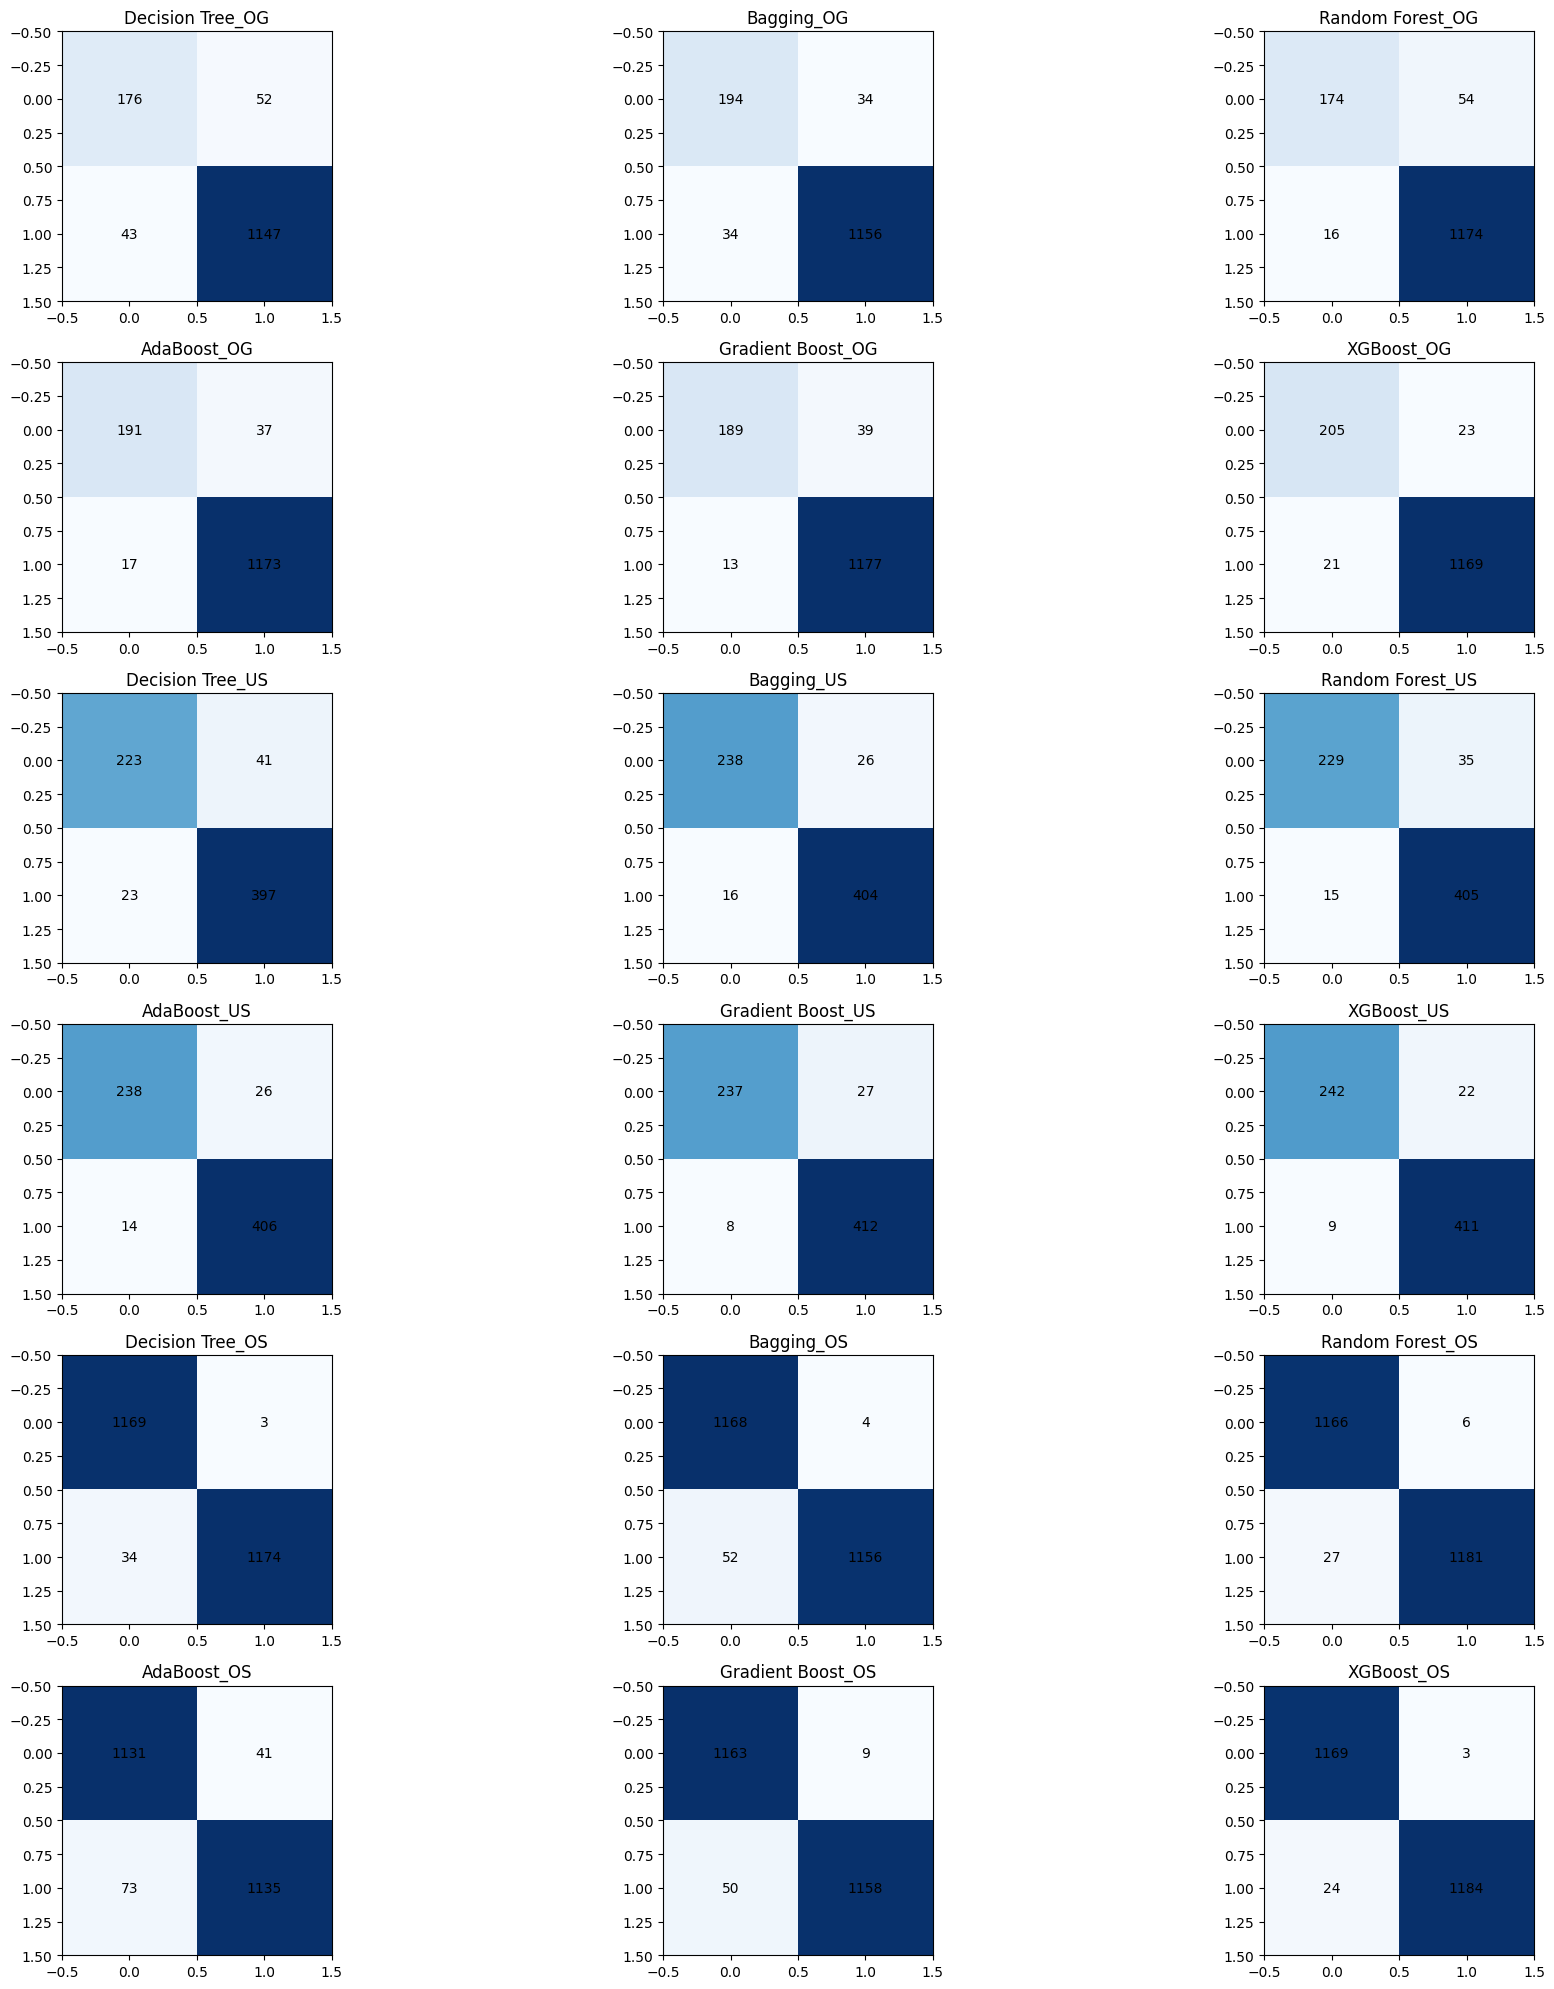

In [ ]:
# Function 7: Confusion matrices from the models developed during the train phase

plot_train_confusion_matrix()

**** The top three models with the best over all performance are from the oversampled minortiy group. However when cosidering recal the top three models are from the the group trainied on the the orginal stratified data. Becasue the tuning and testing processes will not utilize alternative sampling methods but be conducted with teh orignal straified data, the top three models trainined on over sampled data and the top three models trainined on the orgianl stratified data will proceed to the hyper-parameter tuning phase. The models trianed on the majority undersampled data performed poorly compared to the other methods accross the board.

# Model Tuning

The hyper-parameter tuning method selected is the RandomSearch funtion form the sklearn libray. RandomSearch randomly samples hyperparameters from a defined search space, efficiently exploring various combinations. By evaluating model performance through cross-validation, it identifies the best hyperparameter set. While lacking systematic exploration, it remains effective, especially in large search spaces, offering a balance between exploration and computational efficiency.

Training Section / Sampling Method
- Orginal Stratafied Data
  Model Order:
  - AdaBoost Classifier
  - Gradient Boost Classifier
  - XGBoost Clssifier
- Over sampled
  - Decison Tree
  - Random Forest
  - XGBoost

Naming Key
OG = orignal stratified data
OS = over-sampled minority class

## Tune Hyper-Parameters

In [ ]:
# Define the parameter grid for AdaBoost
adaboost_og_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Perform random hyperparameter tuning
rand_search_adaboost_og = RandomizedSearchCV(adaboost_og_model, param_distributions=adaboost_og_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1)
rand_search_adaboost_og.fit(X_val_train, y_val_train)

# Get the best estimator
best_adaboost_og_model = rand_search_adaboost_og.best_estimator_

# Test the best model
y_pred_adaboost_og_val = best_adaboost_og_model.predict(X_val_test)

# Calculate scores
adaboost_og_accuracy_val = accuracy_score(y_val_test, y_pred_adaboost_og_val)
adaboost_og_precision_val = precision_score(y_val_test, y_pred_adaboost_og_val, average='binary')
adaboost_og_recall_val = recall_score(y_val_test, y_pred_adaboost_og_val, average='binary')
adaboost_og_f1_val = f1_score(y_val_test, y_pred_adaboost_og_val, average='binary')

# Generate confusion matrix
adaboost_og_val_conf_matrix = confusion_matrix(y_val_test, y_pred_adaboost_og_val)

In [ ]:
# Define the parameter grid for Gradient Boosting
gradient_boost_og_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': [None]
}

# Perform random hyperparameter tuning
rand_search_gradient_boost_og = RandomizedSearchCV(gradient_boost_og_model, param_distributions=gradient_boost_og_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1)
rand_search_gradient_boost_og.fit(X_val_train, y_val_train)

# Get the best estimator
best_gradient_boost_og_model = rand_search_gradient_boost_og.best_estimator_

# Test the best model
y_pred_gradient_boost_og_val = best_gradient_boost_og_model.predict(X_val_test)

# Calculate scores
gradient_boost_og_accuracy_val = accuracy_score(y_val_test, y_pred_gradient_boost_og_val)
gradient_boost_og_precision_val = precision_score(y_val_test, y_pred_gradient_boost_og_val, average='binary')
gradient_boost_og_recall_val = recall_score(y_val_test, y_pred_gradient_boost_og_val, average='binary')
gradient_boost_og_f1_val = f1_score(y_val_test, y_pred_gradient_boost_og_val, average='binary')

# Generate confusion matrix
gradient_boost_og_val_conf_matrix = confusion_matrix(y_val_test, y_pred_gradient_boost_og_val)

In [ ]:
# Define the parameter grid for XGBoost
xgboost_og_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0]
}

# Perform random hyperparameter tuning
rand_search_xgboost_og = RandomizedSearchCV(xgboost_og_model, param_distributions=xgboost_og_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1)
rand_search_xgboost_og.fit(X_val_train, y_val_train)

# Get the best estimator
best_xgboost_og_model = rand_search_xgboost_og.best_estimator_

# Test the best model
y_pred_xgboost_og_val = best_xgboost_og_model.predict(X_val_test)

# Calculate scores
xgboost_og_accuracy_val = accuracy_score(y_val_test, y_pred_xgboost_og_val)
xgboost_og_precision_val = precision_score(y_val_test, y_pred_xgboost_og_val, average='binary')
xgboost_og_recall_val = recall_score(y_val_test, y_pred_xgboost_og_val, average='binary')
xgboost_og_f1_val = f1_score(y_val_test, y_pred_xgboost_og_val, average='binary')

# Generate confusion matrix
xgboost_og_val_conf_matrix = confusion_matrix(y_val_test, y_pred_xgboost_og_val)

In [ ]:
# Define hyperparameter grid for Decision Tree with oversampling
dt_os_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform random hyperparameter tuning
rand_search_dt_os = RandomizedSearchCV(dt_os_model, param_distributions=dt_os_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1, error_score='raise')
rand_search_dt_os.fit(X_val_train, y_val_train)

# Get the best estimator
best_dt_os_model = rand_search_dt_os.best_estimator_

# Test the best model
y_pred_dt_os_val = best_dt_os_model.predict(X_val_test)

# Calculate scores
dt_os_accuracy_val = accuracy_score(y_val_test, y_pred_dt_os_val)
dt_os_precision_val = precision_score(y_val_test, y_pred_dt_os_val, average='binary')
dt_os_recall_val = recall_score(y_val_test, y_pred_dt_os_val, average='binary')
dt_os_f1_val = f1_score(y_val_test, y_pred_dt_os_val, average='binary')

# Generate confusion matrix
dt_os_val_conf_matrix_val = confusion_matrix(y_val_test, y_pred_dt_os_val)

In [ ]:
# Define hyperparameter grid for Random Forest with oversampling
rf_os_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform random hyperparameter tuning
rand_search_rf_os = RandomizedSearchCV(random_forest_os_model, param_distributions=rf_os_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1)
rand_search_rf_os.fit(X_val_train, y_val_train)

# Get the best estimator
best_rf_os_model = rand_search_rf_os.best_estimator_

# Test the best model
y_pred_rf_os_val = best_rf_os_model.predict(X_val_test)

# Calculate scores
rf_os_accuracy_val = accuracy_score(y_val_test, y_pred_rf_os_val)
rf_os_precision_val = precision_score(y_val_test, y_pred_rf_os_val, average='binary')
rf_os_recall_val = recall_score(y_val_test, y_pred_rf_os_val, average='binary')
rf_os_f1_val = f1_score(y_val_test, y_pred_rf_os_val, average='binary')

# Generate confusion matrix
rf_os_val_conf_matrix = confusion_matrix(y_val_test, y_pred_rf_os_val)

In [ ]:
# Define the parameter grid for XGBoost
xgboost_os_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0]
}

# Initialize the XGBoost classifier
xgboost_os_model = xgb.XGBClassifier(random_state=42)

# Perform random hyperparameter tuning
rand_search_xgboost_os = RandomizedSearchCV(estimator=xgboost_os_model, param_distributions=xgboost_os_param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1)
rand_search_xgboost_os.fit(X_val_train, y_val_train)

# Get the best estimator
best_xgboost_os_model = rand_search_xgboost_os.best_estimator_

# Test the best XGBoost classifier
y_pred_xgboost_val = best_xgboost_os_model.predict(X_val_test)

# Calculate scores
xgboost_os_accuracy_val = accuracy_score(y_val_test, y_pred_xgboost_val)
xgboost_os_precision_val = precision_score(y_val_test, y_pred_xgboost_val, average='binary')
xgboost_os_recall_val = recall_score(y_val_test, y_pred_xgboost_val, average='binary')
xgboost_os_f1_val = f1_score(y_val_test, y_pred_xgboost_val, average='binary')

# Generate a confusion matrix
xgboost_os_val_conf_matrix_val = confusion_matrix(y_val_test, y_pred_xgboost_val)


## Hyper Parameter Tune Evaluation

In [ ]:
# Function 8: Compiled hyperparamteres from all models further developed in the tune phase

generate_hyperparameters_table()

,n_estimators,learning_rate,algorithm,subsample,min_samples_split,min_samples_leaf,max_features,max_depth,reg_lambda,reg_alpha,min_child_weight,gamma,colsample_bytree,bootstrap
Model,,,,,,,,,,,,,,
AdaBoost,200,0.3,SAMME.R,na,na,na,na,na,na,na,na,na,na,na
Gradient Boosting,200,0.1,na,1.0,5,4,None,7,na,na,na,na,na,na
XGBoost,200,0.1,na,1.0,na,na,na,3,0.1,1,1,0,0.8,na
Decision Tree with Oversampling,na,na,na,na,2,1,na,5,na,na,na,na,na,na
Random Forest with Oversampling,50,na,na,na,2,1,na,None,na,na,na,na,na,False
XGBoost with Oversampling,200,0.1,na,1.0,na,na,na,3,0.1,1,1,0,0.8,na


In [122]:
# Funciton 9: Compiled scored from the modles further developed during th etune phase

combined_validate_scores()

Accuracy  Precision    Recall  F1 Score  \
Original    Best AdaBoost_OG        0.957237   0.968992  0.980392  0.974659   
            Best Gradient Boost_OG  0.950658   0.958015  0.984314  0.970986   
            Best XGBoost_OG         0.963816   0.972868  0.984314  0.978558   
OverSampled Best Decision Tree_OS   0.930921   0.950000  0.968627  0.959223   
            Best Random Forest_OS   0.937500   0.953846  0.972549  0.963107   
            Best XGBoost_OS         0.963816   0.972868  0.984314  0.978558   

                                        Mean  
Original    Best AdaBoost_OG        0.970320  
            Best Gradient Boost_OG  0.965993  
            Best XGBoost_OG         0.974889  
OverSampled Best Decision Tree_OS   0.952193  
            Best Random Forest_OS   0.956750  
            Best XGBoost_OS         0.974889

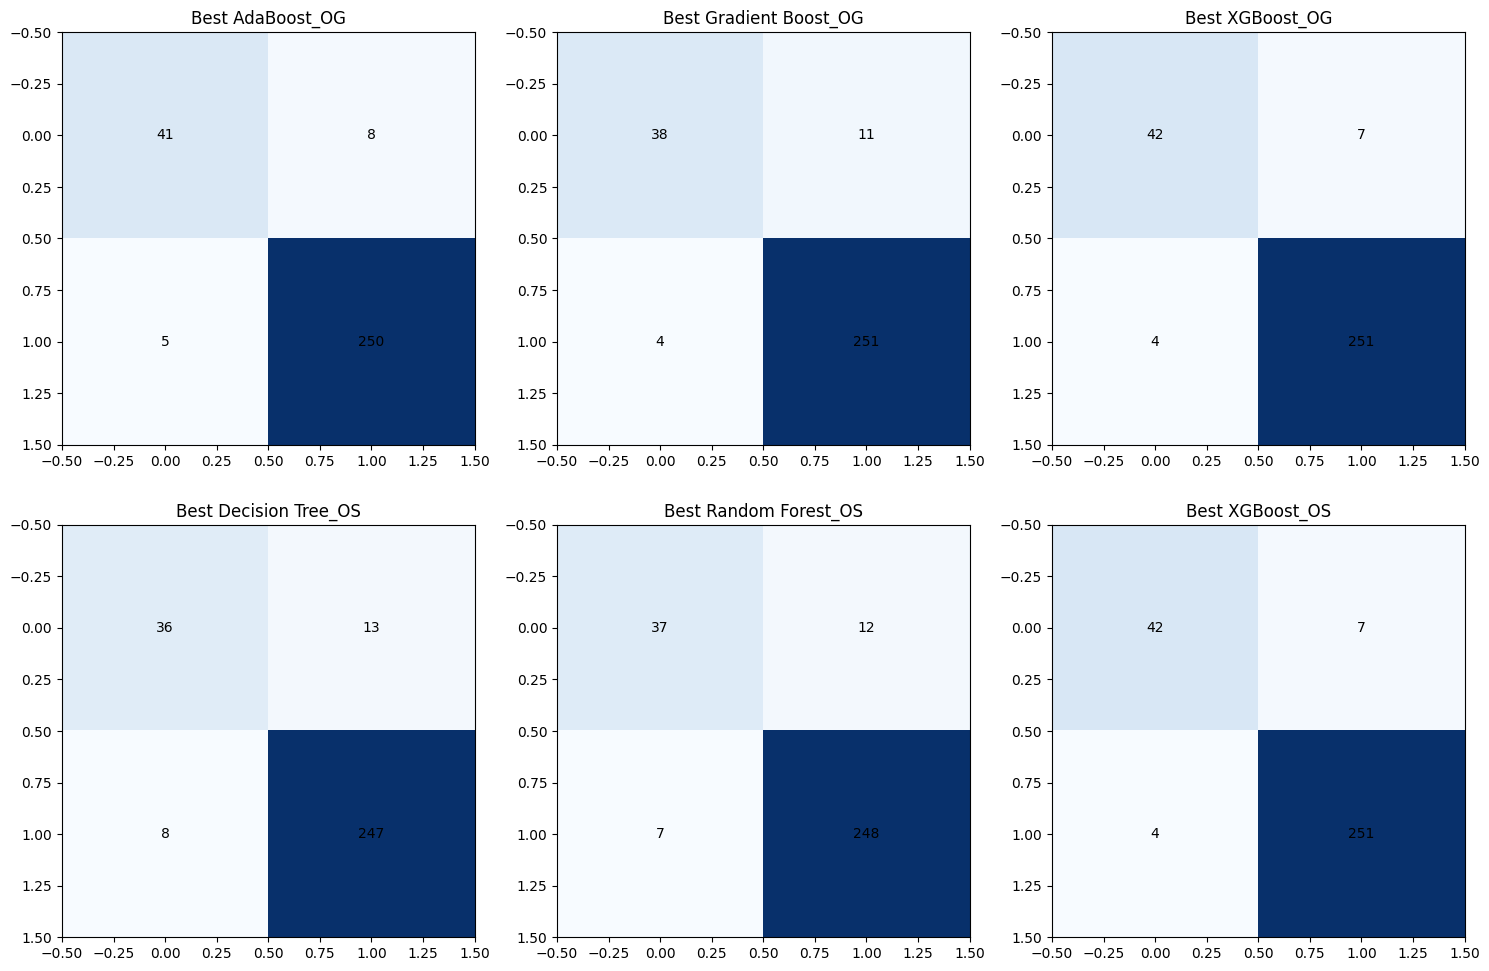

In [ ]:
# Function 10: Confusion matricies from the models further developed during the tune phase.

plot_validate_confusion_matrix()

Tuning Section Comments                              
** After hyperparameter tuning the fourth best performing model from the training phase (XGBoost_OG) shifted to the top performing spot overall and a tied for the top spot for recall. This re-enforces the importance of considering how valiation and testing data compares to the training data. The Tuned version of the XGBoost ttrained on the orginal stratified data will be utilized to make Churn predicitons on the test data.

# Score Final Model Predicitons

In [ ]:
y_pred_test = best_xgboost_og_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Get the confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

In [ ]:
# Function 11: Final model perfromace scores

test_scores()

,Accuracy,Precision,Recall,F1 Score,Mean
Best Gradient Boost_OG,0.953289,0.962394,0.982759,0.97247,0.967728


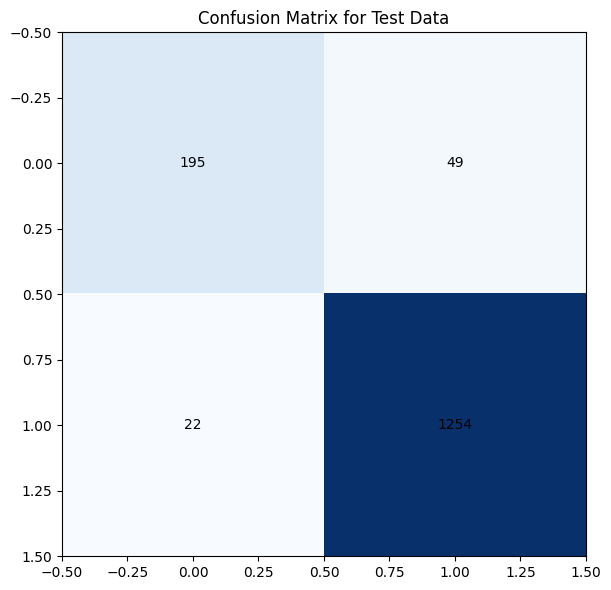

In [ ]:
# Function 12: Final model confusion matrix

plot_test_confusion_matrix()

*** The Best XGBoost_OG model maintianed a high level of overall and recall performance when delpoyed on unseen data with imbalanced Y varible classes. I recommend the organization deplot this model to help inform the department responsible for customer retetion to on whom to focus retention efforst and to detrremine which retention efforst are effective and which are not.